# 关键词提取

## 加载库

In [4]:
import os
from gensim import corpora, models, similarities
from pprint import pprint
from matplotlib import pyplot as plt
import logging
from gensim import corpora
import numpy as np 
from collections import defaultdict
import math
import operator
import jieba
jieba.load_userdict("../data/dict.txt")
from gensim.models import CoherenceModel
np.random.seed(1) # 设置随即种子数，以便相同的设置能跑出相同的结果，可复现

Building prefix dict from the default dictionary ...
Loading model from cache D:\Users\w9007059\AppData\Local\Temp\jieba.cache
Loading model cost 0.835 seconds.
Prefix dict has been built successfully.


## 函数

In [5]:
# step1 : 加载文本数据
def load_data(file):
    docs = []
    with open(file,encoding="utf-8") as f:
        for line in f.readlines():
            docs.append(line.strip())
    return docs

# step2 : 数据分词处理
def data_process(documents,stop_word_path='../data/stop_words.txt',freq=5):
    '''
        功能：数据分词处理
        input:
            documents       String List   文档信息 
            stop_word_path  String        停用词 路径 
            frep:           int           频率
        return:  
            texts           String List   分词后的 文本
    '''
    stop_word = [line.strip() for line in open(stop_word_path,encoding="utf-8").readlines() ]
    stoplist = list(set(stop_word))
    stoplist.append(" ")
    texts = [[word for word in list(jieba.cut(document, cut_all=False)) if word not in stoplist]
         for document in documents]
    # 去掉只出现低于 freq 次的单词
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > freq]
             for text in texts]
    return texts

## 加载数据

In [7]:
doc_path = "../data/corpus.txt"
stop_word_path='../data/stop_words.txt'
freq=5
origin_docs = load_data(doc_path)
docs = data_process(origin_docs,stop_word_path,freq)
docs[0:1]

[['中国', '本周', '新冠', '疫情', '中国', '包括', '北京', '疫情', '本周', '北京', '中国', '当局']]

## 常用的关键词提取方法介绍

- 方法类别介绍
    - TF-IDF算法
    - TextRank算法
    - LDA主题模型关键词提取算法
    - 互信息关键词提取算法
    - 卡方检验关键词提取算法
    - 基于树模型的关键词提取算法

### TF-IDF算法

#### 理类学习

- 词频 （Term Frequency，TF）
  - 介绍：体现 词 在 句子 中出现的频率；
  - 问题：
    - 当一个句子长度的增加，句子中 每一个 出现的次数 也会随之增加，导致该值容易偏向长句子；
    - 解决方法：
      - 需要做归一化（词频除以句子总字数）
  - 公式

![](img/20200809105640.png)

- 逆文本频率(Inverse Document Frequency，IDF)
  - 介绍：体现 词 在文档 中出现的频率
  - 方式：某一特定词语的IDF，可以由总句子数目除以包含该词语的句子的数目，再将得到的商取对数得到；
  - 作用：如果包含词条t的文档越少, IDF越大，则说明词条具有很好的类别区分能力
  - 公式：

![](img/20200809110034.png)

- TF-IDF
    - 介绍：某一特定句子内的高词语频率，以及该词语在整个文档集合中的低文档频率，可以产生出高权重的TF-IDF。因此，TF-IDF倾向于过滤掉常见的词语，保留重要的词语。
    - 优点：
      - 容易理解；
      - 容易实现；
    - 缺点：
      - 其简单结构并没有考虑词语的语义信息，无法处理一词多义与一义多词的情况

![](img/20200809110358.png)

- 应用
  - 搜索引擎；
  - 关键词提取；
  - 文本相似性；
  - 文本摘要

#### 实战演练

##### 手撸版

In [59]:
"""
函数说明：特征选择TF-IDF算法
Parameters:
     list_words:词列表
Returns:
     dict_feature_select:特征选择词字典
"""
def feature_select(list_words):
    sent_keyword_list = []
    for word_list in list_words:
        #总词频统计
        doc_frequency=defaultdict(int)
        for i in word_list:
            doc_frequency[i]+=1
 
        #计算每个词的TF值
        word_tf={}  #存储没个词的tf值
        for i in doc_frequency:
            word_tf[i]=doc_frequency[i]/sum(doc_frequency.values())

        #计算每个词的IDF值
        doc_num=len(list_words)
        word_idf={} #存储每个词的idf值
        word_doc=defaultdict(int) #存储包含该词的文档数
        for i in doc_frequency:
            for j in list_words:
                if i in j:
                    word_doc[i]+=1
        for i in doc_frequency:
            word_idf[i]=math.log(doc_num/(word_doc[i]+1))

        #计算每个词的TF*IDF的值
        word_tf_idf={}
        for i in doc_frequency:
            word_tf_idf[i]=word_tf[i]*word_idf[i]
 
        # 对字典按值由大到小排序
        dict_feature_select=sorted(word_tf_idf.items(),key=operator.itemgetter(1),reverse=True)
        sent_keyword_list.append(dict_feature_select[0:5])
    return sent_keyword_list

In [60]:
features=feature_select(docs) #所有词的TF-IDF值
print(len(features))
for feature in features:
    print(feature)

100
[('北京', 0.44321000615546297), ('本周', 0.3837641821656743), ('疫情', 0.2767885344702751), ('中国', 0.24856306833596672), ('当局', 0.23445089306333636)]
[('香港', 0.8666204143875924), ('本周', 0.26568289534546685), ('反对', 0.19428681879294274), ('BBC', 0.16979037793767088), ('回应', 0.10227923218972224)]
[('点', 0.6743380571769196), ('本周', 0.17712193023031123), ('经济', 0.17712193023031123), ('疫情', 0.12774855437089622), ('7', 0.12004982678958988)]
[('爆发', 0.21022682621431513), ('香港', 0.16941451709832633), ('北京', 0.13996105457540936), ('月', 0.10754223658231381), ('气溶胶', 0.10511341310715756)]
[('当局', 0.29614849650105646), ('6', 0.1748138112443843), ('不明', 0.15767011966073635), ('爆发', 0.15767011966073635), ('事件', 0.15767011966073635)]
[('中国', 0.2339417113750275), ('7', 0.18360561744290216), ('超过', 0.15642706099604575), ('万', 0.15642706099604575), ('发现', 0.15642706099604575)]
[('日', 0.38088441723126687), ('7', 0.24009965357917976), ('月', 0.2357656725073803), ('9', 0.18522658528091324), ('更', 0.1512394504

limit_output extension: Maximum message size of 10000 exceeded with 14327 characters

##### Sklearn实现TF-IDF算法

In [49]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
docs_list = [" ".join(doc) for doc in docs]

#该类会统计每个词语的tf-idf权值
tf_idf_Vectorizer = TfidfVectorizer()
#将文本转为词频矩阵并计算tf-idf
tfidf_mat  = tf_idf_Vectorizer.fit_transform(docs_list)
vocab_dict =tf_idf_Vectorizer.vocabulary_#获得所有文本的关键字和其位置的dict
#将tf-idf矩阵抽取出来，元素a[i][j]表示j词在i类文本中的tf-idf权重
weight = tfidf_mat.toarray()
feat = np.argsort(-weight)#降序排序
total_key_word = []
for l in range(len(docs_list)):
    values_word = []
    for j in range(5):#获取每类文本的5个关键字
        keyword = [k for k,v in vocab_dict.items() if v ==feat[l,j]]
        values_word.append(keyword[0])
    total_key_word.append(values_word)

In [50]:
for key_word in total_key_word:
    print(key_word)

['北京', '本周', '中国', '疫情', '当局']
['香港', '本周', '反对', 'bbc', '回应']
['本周', '经济', '中国', '疫情', '支持']
['爆发', '香港', '北京', '病毒', '疫情']
['当局', '中国', '事件', '爆发', '不明']
['中国', '超过', '发现', '新冠', '疫情']
['10', '电信', '爆发', '消息', '测试']
['研究', '侦察机', '消息', '美国', '显示']
['美国', '反对', '中国', '日本', '事件']
['侦察机', '美国', '中国', '事件', '许可']
['英国', '政治', '中国', '专家', '电信']
['提供', '中国', '情况', '公司', '国家']
['中国', '英国', '日本', '工作', '北京']
['表态', '组织', '超过', '研究', '世界']
['传播', '空气', '病毒', '新冠', '距离']
['传播', '气溶胶', '空气', '病毒', '世界卫生组织']
['空气', '传播', '显示', '病毒', '新冠']
['传播', '病毒', '空气', '距离', '世界卫生组织']
['整形', '诊所', '工作', '新冠', '疫情']
['在家', '手术', '期间', '隔离', '工作']
['诊所', '增加', '整形', '人数', '发言人']
['日本', '疫情', '手术', '期间', '诊所']
['哈萨克斯坦', '肺炎', '卫生部', '不明', '新冠肺炎']
['哈萨克斯坦', '肺炎', '中国', '不明', '中国大使馆']
['中国大使馆', '肺炎', '哈萨克斯坦', '不明', '中国']
['卫生部', '症状', '该国', '哈萨克斯坦', '发现']
['检测', '哈萨克斯坦', '肺炎', '卫生部', '冠状病毒']
['哈萨克斯坦', '组织', '肺炎', '冠状病毒', '当局']
['疫情', '该国', '哈萨克斯坦', '新冠', '肺炎']
['哈萨克斯坦', '新冠', '隔离', '社交', '总统']
['冠状病毒', '博尔索', '纳

##### jieba 实现 TF-IDF 

In [52]:
import jieba.analyse
 
text='关键词是能够表达文档中心内容的词语，常用于计算机系统标引论文内容特征、信息检索、系统汇集以供读者检阅。关键词提取是文本挖掘领域的一个分支，是文本检索、文档比较、摘要生成、文档分类和聚类等文本挖掘研究的基础性工作'

for doc in docs_list:
    keywords=jieba.analyse.extract_tags(doc, topK=5, withWeight=True, allowPOS=())
    print(keywords)

[('疫情', 1.3477578533583332), ('新冠', 0.9962306252416666), ('本周', 0.972621126705), ('北京', 0.7779003847866667), ('中国', 0.756830171665)]
[('香港', 1.6952004552875), ('BBC', 0.9962306252416666), ('本周', 0.72946584502875), ('反对', 0.46703171161083334), ('回应', 0.3104253012429167)]
[('疫情', 1.0782062826866665), ('新冠', 0.7969845001933333), ('BBC', 0.7969845001933333), ('本周', 0.778096901364), ('中国', 0.605464137332)]
[('新冠', 0.9195975002230768), ('疫情', 0.6220420861653846), ('爆发', 0.607387069014359), ('病毒', 0.5705823308092308), ('气溶胶', 0.5367533562820512)]
[('当局', 1.0374442661157144), ('BBC', 0.8539119644928571), ('新冠', 0.8539119644928571), ('中国', 0.6487115757128572), ('疫情', 0.5776105085821428)]
[('中国', 1.3454758607377777), ('新冠', 1.3283075003222222), ('疫情', 0.8985052355722222), ('超过', 0.5043131813733334), ('发现', 0.4858942069777778)]
[]
[('侦察机', 1.0546427836344), ('研究', 0.691800257592), ('美国', 0.4987915477992), ('报道', 0.47043257433279995), ('消息', 0.4031915804936)]
[('美国', 0.9975830955984), ('反对', 0.448

limit_output extension: Maximum message size of 10000 exceeded with 13254 characters

### PageRank算法

#### 理论篇

- 论文：[The PageRank Citation Ranking: Bringing Order to the Web](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf)
- 介绍：通过计算网页链接的数量和质量来粗略估计网页的重要性，算法创立之初即应用在谷歌的搜索引擎中，对网页进行排名；
- 核心思想：
  - 链接数量：如果一个网页被越多的其他网页链接，说明这个网页越重要，即该网页的PR值（PageRank值）会相对较高；
  - 链接质量：如果一个网页被一个越高权值的网页链接，也能表明这个网页越重要，即一个PR值很高的网页链接到一个其他网页，那么被链接到的网页的PR值会相应地因此而提高；
- 计算公式

![](img/20200809121756.png)

> $S(V_i)$ ： 网页 i 的 重要性；
> 
> d：托尼系数；
> 
> $ln(V_i)$：整个互联网中所存在的有指向网页 i 的链接的网页集合；
> 
> $Out(V_j)$： 网页 j 中存在的指向所有外部网页的链接的集合；
> 
> $Out(V_j)$：该集合中元素的个数；

### TextRank算法

#### 理论篇

- 论文：[TextRank: Bringing Order into Texts](https://web.eecs.umich.edu/~mihalcea/papers/mihalcea.emnlp04.pdf)
- 介绍：一种基于图的用于关键词抽取和文档摘要的排序算法，由谷歌的网页重要性排序算法PageRank算法改进而来，它利用一篇文档内部的词语间的共现信息(语义)便可以抽取关键词，它能够从一个给定的文本中抽取出该文本的关键词、关键词组，并使用抽取式的自动文摘方法抽取出该文本的关键句；
- 基本思想：将文档看作一个词的网络，该网络中的链接表示词与词之间的语义关系；
- 计算公式：

![](img/20200809122329.png)

#### 实战篇

##### 基于Textrank4zh的TextRank算法实现

In [2]:
from textrank4zh import TextRank4Keyword, TextRank4Sentence
import pandas as pd
import numpy as np
 
#关键词抽取
def keywords_extraction(text):
    tr4w = TextRank4Keyword(allow_speech_tags=['n', 'nr', 'nrfg', 'ns', 'nt', 'nz'])
    # allow_speech_tags   --词性列表，用于过滤某些词性的词
    tr4w.analyze(text=text, window=2, lower=True, vertex_source='all_filters', edge_source='no_stop_words',
                 pagerank_config={'alpha': 0.85, })
    # text    --  文本内容，字符串
    # window  --  窗口大小，int，用来构造单词之间的边。默认值为2
    # lower   --  是否将英文文本转换为小写，默认值为False
    # vertex_source  -- 选择使用words_no_filter, words_no_stop_words, words_all_filters中的哪一个来构造pagerank对应的图中的节点
    #                -- 默认值为`'all_filters'`，可选值为`'no_filter', 'no_stop_words', 'all_filters'
    # edge_source  -- 选择使用words_no_filter, words_no_stop_words, words_all_filters中的哪一个来构造pagerank对应的图中的节点之间的边
    #              -- 默认值为`'no_stop_words'`，可选值为`'no_filter', 'no_stop_words', 'all_filters'`。边的构造要结合`window`参数
 
    # pagerank_config  -- pagerank算法参数配置，阻尼系数为0.85
    keywords = tr4w.get_keywords(num=6, word_min_len=2)
    # num           --  返回关键词数量
    # word_min_len  --  词的最小长度，默认值为1
    return keywords
 
#关键短语抽取
def keyphrases_extraction(text):
    tr4w = TextRank4Keyword()
    tr4w.analyze(text=text, window=2, lower=True, vertex_source='all_filters', edge_source='no_stop_words',
                 pagerank_config={'alpha': 0.85, })
    keyphrases = tr4w.get_keyphrases(keywords_num=6, min_occur_num=1)
    # keywords_num    --  抽取的关键词数量
    # min_occur_num   --  关键短语在文中的最少出现次数
    return keyphrases
 
#关键句抽取
def keysentences_extraction(text):
    tr4s = TextRank4Sentence()
    tr4s.analyze(text, lower=True, source='all_filters')
    # text    -- 文本内容，字符串
    # lower   -- 是否将英文文本转换为小写，默认值为False
    # source  -- 选择使用words_no_filter, words_no_stop_words, words_all_filters中的哪一个来生成句子之间的相似度。
    # 		  -- 默认值为`'all_filters'`，可选值为`'no_filter', 'no_stop_words', 'all_filters'
    # sim_func -- 指定计算句子相似度的函数
 
    # 获取最重要的num个长度大于等于sentence_min_len的句子用来生成摘要
    keysentences = tr4s.get_key_sentences(num=3, sentence_min_len=6)
    return keysentences
 


In [9]:
for text in origin_docs:
    #关键词抽取
    keywords=keywords_extraction(text)
    print(keywords)
 
    #关键短语抽取
    keyphrases=keyphrases_extraction(text)
    print(keyphrases)
 
    #关键句抽取
    keysentences=keysentences_extraction(text)
    print(keysentences)

[{'word': '疫情', 'weight': 0.10773822523112758}, {'word': '新一轮', 'weight': 0.10773822523112758}, {'word': '中国', 'weight': 0.10205029609105039}, {'word': '方面', 'weight': 0.10205029609105039}, {'word': '大陆', 'weight': 0.09919451718695786}, {'word': '舞弊', 'weight': 0.08298755186721993}]
[]
[{'index': 1, 'sentence': '本周，因新冠疫情延期一月的中国高考拉开帷幕，但高考前多起包括冒名顶替在内的舞弊案件引发对公平性的讨论', 'weight': 0.28003453726823174}, {'index': 3, 'sentence': '同样在北京，知名法学家许章润被警察带走，最近几年他发表多篇文章批评中国当局', 'weight': 0.2542782586276606}, {'index': 2, 'sentence': '北京新一轮疫情得到控制，本周首现零新增', 'weight': 0.23561733383003364}]
[{'word': '香港', 'weight': 0.1285260989050496}, {'word': '移民', 'weight': 0.07779005833762835}, {'word': '入籍', 'weight': 0.05570067956084056}, {'word': '法律', 'weight': 0.04878048780487805}, {'word': '重点', 'weight': 0.04878048780487805}, {'word': '护照', 'weight': 0.04878048780487805}]
['香港移民']
[{'index': 2, 'sentence': '西方国家对香港《国安法》反应强烈，此前英国承诺为香港BNO护照持有者开启移民入籍路径，本周BBC中文采访探讨这一政策是否会导致香港移民潮', 'weight': 0.26955405823175094}, {'i

[{'word': '病毒', 'weight': 0.09916608906968882}, {'word': '距离', 'weight': 0.07542283781649815}, {'word': '世界卫生组织', 'weight': 0.0670927965909606}, {'word': '建议', 'weight': 0.0670927965909606}, {'word': '预防措施', 'weight': 0.051679586563307484}, {'word': '全面', 'weight': 0.051679586563307484}]
['采取预防措施', '新冠病毒', '传播新冠病毒']
[{'index': 3, 'sentence': '世界卫生组织表态称不排除在室内和封闭空间内气溶胶传播新冠病毒的可能性，但仍然需要进行更多研究和取证', 'weight': 0.22885908156150375}, {'index': 4, 'sentence': '世界卫生组织建议，无论结果怎样，公众应该采取全面预防措施，保持社交距离、在适当场合戴口罩、勤洗手，等等', 'weight': 0.2085161312916575}, {'index': 0, 'sentence': '这一公开信题为《到了该解决新冠病毒空气传播问题的时候》，呼吁世卫组织更加重视新冠病毒通过空气传播的问题', 'weight': 0.1980029097247755}]
[{'word': '病毒', 'weight': 0.07550335899233676}, {'word': '空气', 'weight': 0.07388882956407254}, {'word': '官方', 'weight': 0.06558992185847765}, {'word': '新闻', 'weight': 0.0449438202247191}, {'word': '发布会', 'weight': 0.0449438202247191}, {'word': '卫生防疫', 'weight': 0.0449438202247191}]
['病毒空气传播', '气溶胶传播', '空气传播病毒']
[{'index': 6, 'sentence': '世界卫生组织承认，

limit_output extension: Maximum message size of 10000 exceeded with 10320 characters

##### 基于jieba的TextRank算法实现

In [10]:
import jieba.analyse
def keywords_textrank(text):
    keywords = jieba.analyse.textrank(text, topK=6)
    return keywords

In [11]:
for text in origin_docs:
    #关键词抽取
    keywords=keywords_textrank(text)
    print(keywords)

['中国', '北京', '疫情', '公平性', '股市', '高考']
['香港', '移民', '虚伪性', '干涉', '相关', '机构']
['经济', '中国', '股市', '暴涨', '疫情', '上涨']
['病毒', '新冠', '爆发', '北京', '气溶胶', '传播']
['中国', '当局', '文章', '带走', '疫情', '知识分子']
['中国', '高考', '民间', '山东省', '出题', '还有']
['民主派', '选举', '举行', '传统', '阵营', '决定']
['中国', '研究', '报道', '美国', '广东', '消息']
['美国', '地区', '南海', '中国', '军演', '航行']
['中国', '美国', '侦察机', '战斗机', '事件', '迫降']
['中国', '英国', '公司', '政治', '包括', '安置']
['中国', '称为', '参加', '提供', '董事', '生活']
['覆盖', '中国', '进行', '英国', '蜜罐', '俄罗斯']
['世卫', '组织', '流行', '表示', '表态', '应对']
['传播', '空气', '新冠', '病毒', '预防措施', '采取']
['传播', '空气', '病毒', '分散', '气溶胶', '证据']
['传播', '传染', '怀疑', '空气', '显示', '病毒']
['病毒', '传播', '空气', '建议', '认为', '浓度']
['新冠', '疫情', '外科', '隐藏', '关门', '客源']
['手术', '考虑', '人们', '杆菌', '美国', '韩国']
['诊所', '增加', '韩国', '措施', '当地人', '旅行']
['疫情', '治疗', '日本', '协会', '希望', '手术']
['肺炎', '予以', '中国', '新冠肺炎', '修改', '研究']
['肺炎', '公告', '中国', '公民', '不明', '防范']
['中国', '肺炎', '不明', '位于', '媒体', '继续']
['症状', '发布', '诊断', '支持', '标准', '进行']
['检测', '报道', '强调', '核酸

##### 基于SnowNLP的TextRank算法实现

In [12]:
from snownlp import SnowNLP

In [13]:
for text in origin_docs:
    # 基于SnowNLP的textrank算法实现
    snlp=SnowNLP(text)
    print(snlp.keywords(5))  #关键词抽取
    print(snlp.summary(3))   #关键句抽取

['中国', '高考', '年', '疫情', '一月']
['因新冠疫情延期一月的中国高考拉开帷幕', '北京新一轮疫情得到控制', '最近几年他发表多篇文章批评中国当局']
['香港', '反对', '移民', '干涉', '本周']
['本周BBC中文采访探讨这一政策是否会导致香港移民潮', '香港《国安法》在香港和海外持续发酵', '西方国家对香港《国安法》反应强烈']
['中国', '连续', '月', '疫情', '年']
['中国股市沪深300指数已连续七个交易日上涨', '中国股市在7月初则迎来一轮暴涨', '促使本轮股市上涨']
['月', '爆发', '新', '病毒', '冠']
['而香港近日爆发第三波新冠病毒疫情', '北京新发地农贸市场新冠疫情爆发近一个月后', '在封闭环境下不排除新冠病毒气溶胶传播途径']
['中国', '月', '6', '法学', '当局']
['许章润是中国知名法学家', '怀疑许被带走与最近几年他发表的批评中国当局的文章有关', '也是清华大学法学教授本周一（7月6日）上午被四川警方从北京家中带走']
['高考', '中国', '上', '公平', '大学']
['山东省被发现有大量考生被冒名顶替上大学的案例', '高考也被许多中国人称赞为是最公平的选拔制度', '今年的中国高考罕见地延期一个月']
['选举', '月', '日', '派', '民主派']
['民主派在7月11日和12日举行初选', '官方提名将于7月18日开始', '四年一次的香港立法会选举将于9月6日举行']
['中国', '日', '侦察机', '美国', '英文']
['美军侦察机分别于7月6日、7日靠近广东侦察', '该研究中心的推特图片还显示', '该研究中心在推特上公布的卫星照片显示']
['美国', '中国', '地区', '南海', '演']
['美国、日本、澳大利亚三国的国防部长本周举行会议后重申反对中国在东海、南海采取的破坏地区局势的行为', '观察人士都注意到美国和中国海军同时在南海军事演习的罕见情况', '美国在军演中有战斗机']
['中国', '美国', '侦察机', '后', '战斗机']
['而美国则认为侦察机是被失控的中国战斗机撞击后迫降', '中美双方就事件该由哪方负责僵持不下', '被中国扣押的24名美国机

['Airtel', 'Bharti', '网络', '丰', '运营']
['印度两大电信运营商Bharti Airtel和沃达丰的供应商中都包含华为', '其最大的电信运营商Reliance Jio', '华为的设备占据了Bharti Airtel现有网络的三分之一']
['印度', '员工', '环球', '报道', '网']
['华为及其在印度的相关企业', '已经在印度招募了8000余名员工', '华为在印度的关闭']
['印度', '华为', '5G', '设备', '运营']
['最不希望看到因5G运营', '印度本土科技不具备5G设备的制造能力', '无论是华为之前提供的服务及设备']
['印度', '会', '供应商', '市场', '5G']
['这将会给欧洲供应商提高价格的时机', '购买5G设备的成本会提高', '通常会比欧洲供应商便宜30%左右']
['会', '中国', '印度', '华为', '出']
['势必会引起中国的一些反制措施', '印度对华为的打压', '倘若印度将华为5G赶出印度市场']
['中国', '印度', '长期', '贸易', '伙伴']
['印度一些产业领域高度依赖中国零部件及原材料', '印度也是中国在南亚的最大贸易伙伴', '中国长期保持印度头号贸易伙伴地位']
['印度', '占', '进口', '出口', '价值']
['2018年中国只在印度进口价值约188亿美元的商品', '而在中国2018年2万亿美元价值的出口商品中', '印度对中国出口占印度出口总额的5.1%']
['印度', '经济', '大', '上', '中国']
['在经济上印度对中国依赖较大', '以上数据表明', '来换取对华为5G的打压']
['德国', '华为', '公司', '当地', '讯']
['称公司过去三年已经缩减与华为的生意往来', '德国电讯（Deutsche Telekom）正不断加强与中国电信技术公司华为的合作', '不过']
['德国', '华为', '电讯', '扩充', '云端']
['其中不少采用了华为提供的设备', '德国电讯的供应商都是华为', '尤其在5G网络、宽频扩充、云端服务以及电视等业务领域']
['德国', '亿', '长', '设备', '欧元']
['文件显示', '如果德国政府反对使用

limit_output extension: Maximum message size of 10000 exceeded with 10235 characters

### 主题模型

#### 函数

In [16]:
def PrintDictionary(dictionary):
    token2id = dictionary.token2id
    dfs = dictionary.dfs
    token_info = {}
    for word in token2id:
        token_info[word] = dict(
            word = word,
            id = token2id[word],
            freq = dfs[token2id[word]]
        )
    token_items = token_info.values()
    token_items = sorted(token_items, key = lambda x:x['id'])
    print('The info of dictionary: ')
    pprint(token_items)
    print('--------------------------')

# 绘图
def Show2dCorpora(corpus):
    nodes = list(corpus)
    ax0 = []
    ax1 = []
    for x in nodes:
#         print(f"x:{x}")
        try:
            ax1.append(x[1][1])
            ax0.append(x[0][1])
        except Exception:
            print(f"x:{x}")
    # print(ax0)
    # print(ax1)
    plt.plot(ax0,ax1,'o')
    plt.show()
    
# step1 : 数据分词处理
def data_process(documents,stop_word_path='../../../data/stop_words.txt',freq=5):
    '''
        功能：数据分词处理
        input:
            documents       String List   文档信息 
            stop_word_path  String        停用词 路径 
            frep:           int           频率
        return:  
            texts           String List   分词后的 文本
    '''
    stop_word = [line.strip() for line in open(stop_word_path,encoding="utf-8").readlines() ]
    stoplist = list(set(stop_word))
    stoplist.append(" ")
    texts = [[word for word in list(jieba.cut(document, cut_all=False)) if word not in stoplist]
         for document in documents]
    # 去掉只出现低于 freq 次的单词
    frequency = defaultdict(int)
    for text in texts:
        for token in text:
            frequency[token] += 1
    texts = [[token for token in text if frequency[token] > freq]
             for text in texts]
    return texts

# 功能：加载 词典
def get_dict(texts):
    '''
        功能：加载 词典
        input:
            texts  String List  分词后的 文本 
        ouput:
            dictionary : Dict   词典
    '''
    dictionary = corpora.Dictionary(texts)   # 生成词典 
    # 将文档存入字典，字典有很多功能，比如
    # diction.token2id 存放的是单词-id key-value对
    # diction.dfs 存放的是单词的出现频率
    dictionary.save('output/deerwester_zh.dict')  # store the dictionary, for future reference
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpus = [dictionary.doc2bow(text) for text in texts]
    corpora.MmCorpus.serialize('output/deerwester_zh.mm', corpus)  # store to disk, for later use
    return dictionary

# 功能：利用指标确定 主题数
def evaluate_coherence_values(Model,dictionary, corpus, texts, limit, start=2, step=3, coherence='c_v'):
    """
        Compute c_v or u_mass coherence for various number of topics
        decs:
            通过CoherenceModel这个类中的两个指标 --- U_Mass Coherence和C_V coherence来判定主题模
            型质量的好坏（对文本的主题区分度效果，即能将混沌的语料切分出人类可理解的主题），这两个指标都是
            数值越大，主题模型的效果越好。

        Parameters:
        ----------
            Model: model  lsi_model or lda_model
            dictionary : Gensim dictionary
            corpus : Gensim corpus
            texts : List of input texts
            limit : Max num of topics
            start: start step
            step： step 
            coherence: 评价指标  c_v  or u_mass

        Returns:
        -------
   
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model =Model(corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence)
        coherence_values.append(coherencemodel.get_coherence())

    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

#### 操作

In [17]:
dictionary = get_dict(docs)

In [18]:
if (os.path.exists("output/deerwester_zh.dict")):
    dictionary = corpora.Dictionary.load('output/deerwester_zh.dict')
    corpus = corpora.MmCorpus('output/deerwester_zh.mm')
    print("Used files generated from first tutorial")
else:
    print("Please run first tutorial to generate data set")

PrintDictionary(dictionary)

Used files generated from first tutorial
The info of dictionary: 
[{'freq': 36, 'id': 0, 'word': '中国'},
 {'freq': 13, 'id': 1, 'word': '包括'},
 {'freq': 6, 'id': 2, 'word': '北京'},
 {'freq': 5, 'id': 3, 'word': '当局'},
 {'freq': 18, 'id': 4, 'word': '新冠'},
 {'freq': 9, 'id': 5, 'word': '本周'},
 {'freq': 18, 'id': 6, 'word': '疫情'},
 {'freq': 10, 'id': 7, 'word': 'BBC'},
 {'freq': 14, 'id': 8, 'word': '会'},
 {'freq': 7, 'id': 9, 'word': '反对'},
 {'freq': 6, 'id': 10, 'word': '回应'},
 {'freq': 21, 'id': 11, 'word': '国家'},
 {'freq': 7, 'id': 12, 'word': '导致'},
 {'freq': 11, 'id': 13, 'word': '措施'},
 {'freq': 19, 'id': 14, 'word': '提供'},
 {'freq': 10, 'id': 15, 'word': '相关'},
 {'freq': 16, 'id': 16, 'word': '称'},
 {'freq': 9, 'id': 17, 'word': '英国'},
 {'freq': 8, 'id': 18, 'word': '这一'},
 {'freq': 3, 'id': 19, 'word': '香港'},
 {'freq': 20, 'id': 20, 'word': '7'},
 {'freq': 9, 'id': 21, 'word': '8'},
 {'freq': 15, 'id': 22, 'word': '市场'},
 {'freq': 12, 'id': 23, 'word': '年'},
 {'freq': 11, 'id': 24

###### LSI 模型

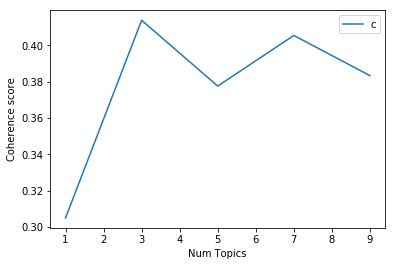

In [19]:
# 利用 LSI 模型中  的 c_v 确定 topics 数
evaluate_coherence_values(models.LsiModel,dictionary=dictionary, corpus=corpus, texts=docs, start=1, limit=10, step=2, coherence='c_v')

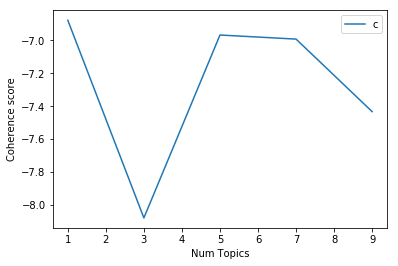

In [20]:
# 利用 LSI 模型中  的 u_mass 确定 topics 数
evaluate_coherence_values(models.LsiModel,dictionary=dictionary, corpus=corpus, texts=docs, start=1, limit=10, step=2, coherence='u_mass')

In [27]:
# 转化为lsi模型, 可用作聚类或分类
lsi_model = models.LsiModel(corpus, id2word=dictionary, num_topics=4)
corpus_lsi = lsi_model[corpus]
list(corpus_lsi)

[[(0, 1.9252097982789478),
  (1, 1.0072047019998105),
  (2, 1.240595022804701),
  (3, -0.038747316921358244)],
 [(0, 1.7065469757757004),
  (1, 0.42206195859821394),
  (2, 0.22656157084613557),
  (3, 0.22949528413825399)],
 [(0, 3.199556817902065),
  (1, 1.570427542650472),
  (2, 1.4206867405237602),
  (3, 0.43655965742545566)],
 [(0, 6.818283441110444),
  (1, 5.489003343512087),
  (2, -2.444380310875518),
  (3, -0.08553479089099676)],
 [(0, 2.8782456170396395),
  (1, 1.718264821033867),
  (2, 1.6393378708934871),
  (3, 0.45677904076973325)],
 [(0, 3.3918927735796047),
  (1, 1.8296799682845464),
  (2, 1.6099511279989178),
  (3, 0.6046552640241379)],
 [(0, 2.566391015193694),
  (1, 1.7183784128808746),
  (2, -0.5508668158279959),
  (3, 1.4062849733456715)],
 [(0, 5.410829027965355),
  (1, 2.875228358467952),
  (2, 2.3337568124483226),
  (3, 1.7917495249631252)],
 [(0, 3.816300701014878),
  (1, 1.163953898810361),
  (2, 3.160448583192698),
  (3, 0.7197842625338233)],
 [(0, 8.372479177043

limit_output extension: Maximum message size of 10000 exceeded with 11043 characters

In [28]:
lsi_model.show_topics(num_words=5)

[(0, '0.409*"中国" + 0.304*"月" + 0.288*"5G" + 0.258*"日" + 0.227*"美国"'),
 (1, '-0.447*"5G" + -0.309*"印度" + -0.292*"设备" + -0.267*"华" + 0.221*"月"'),
 (2, '0.540*"中国" + 0.328*"印度" + -0.308*"传播" + -0.295*"病毒" + 0.254*"美国"'),
 (3, '-0.596*"印度" + -0.398*"传播" + -0.308*"病毒" + -0.265*"空气" + 0.172*"日"')]

In [29]:
# 输出该主题的的词及其词的权重
words_list = lsi_model.show_topic(0, 5)
print('输出该主题的的词及其词的权重:')
print(words_list)

输出该主题的的词及其词的权重:
[('中国', 0.40947967432379434), ('月', 0.3044080351550752), ('5G', 0.28805548829865707), ('日', 0.25756323391392005), ('美国', 0.227145401276353)]


###### LDA 模型

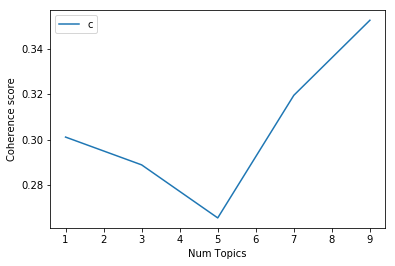

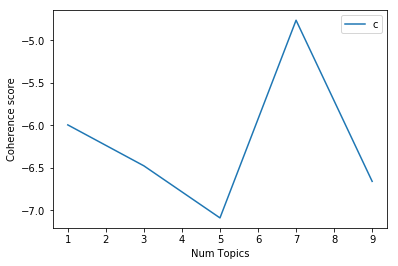

In [30]:
# 利用 LSI 模型中  的 c_v 确定 topics 数
evaluate_coherence_values(models.LdaModel,dictionary=dictionary, corpus=corpus, texts=docs, start=1, limit=10, step=2, coherence='c_v')
# 利用 LSI 模型中  的 u_mass 确定 topics 数
evaluate_coherence_values(models.LdaModel,dictionary=dictionary, corpus=corpus, texts=docs, start=1, limit=10, step=2, coherence='u_mass')

In [37]:
# 转化为lsi模型, 可用作聚类或分类
lda_model = models.LdaModel(corpus, id2word=dictionary, num_topics=7)
corpus_lda = lda_model[corpus]
list(corpus_lda)

[[(0, 0.93393683),
  (1, 0.011008778),
  (2, 0.011002851),
  (3, 0.011046668),
  (4, 0.010993013),
  (5, 0.011004547),
  (6, 0.0110072885)],
 [(3, 0.96817845)],
 [(0, 0.43748325), (3, 0.5359707)],
 [(0, 0.9851553)],
 [(0, 0.9570339)],
 [(0, 0.95229113)],
 [(0, 0.938572),
  (1, 0.010256896),
  (2, 0.010245071),
  (3, 0.010222643),
  (4, 0.01023264),
  (5, 0.0102222385),
  (6, 0.010248494)],
 [(0, 0.514138), (1, 0.46839854)],
 [(1, 0.97225046)],
 [(0, 0.16555926), (1, 0.58721054), (6, 0.23390038)],
 [(0, 0.9739557)],
 [(0, 0.017963348),
  (1, 0.017908784),
  (2, 0.017908089),
  (3, 0.8924755),
  (4, 0.017911583),
  (5, 0.017898828),
  (6, 0.017933877)],
 [(0, 0.969271)],
 [(0, 0.29833066), (2, 0.67300963)],
 [(1, 0.9731766)],
 [(1, 0.7323067), (5, 0.25175333)],
 [(1, 0.9625882)],
 [(1, 0.25815013), (5, 0.7239588)],
 [(1, 0.6761688), (6, 0.29727346)],
 [(1, 0.97907174)],
 [(1, 0.97906286)],
 [(1, 0.9760748)],
 [(0, 0.977409)],
 [(0, 0.95481974)],
 [(0, 0.7398484), (3, 0.2449094)],
 [(0, 0

In [38]:
lda_model.show_topics(num_words=5)

[(0, '0.088*"中国" + 0.047*"月" + 0.046*"日" + 0.035*"哈萨克斯坦" + 0.034*"7"'),
 (1, '0.058*"美国" + 0.030*"病毒" + 0.029*"说" + 0.029*"中国" + 0.028*"传播"'),
 (2, '0.044*"5G" + 0.037*"华" + 0.034*"月" + 0.029*"美国" + 0.028*"华为"'),
 (3, '0.046*"中国" + 0.040*"印度" + 0.036*"哈萨克斯坦" + 0.031*"年" + 0.031*"香港"'),
 (4, '0.086*"5G" + 0.037*"华" + 0.036*"印度" + 0.036*"社会" + 0.030*"国家"'),
 (5, '0.057*"印度" + 0.051*"华" + 0.040*"5G" + 0.039*"设备" + 0.031*"网络"'),
 (6, '0.065*"中国" + 0.056*"印度" + 0.042*"5G" + 0.037*"华为" + 0.021*"欧洲"')]

In [39]:
# 输出该主题的的词及其词的权重
words_list = lda_model.show_topic(0, 5)
print('输出该主题的的词及其词的权重:')
print(words_list)

输出该主题的的词及其词的权重:
[('中国', 0.08835726), ('月', 0.047125064), ('日', 0.045936912), ('哈萨克斯坦', 0.03476224), ('7', 0.034208637)]
